# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Embedding, Dot, Concatenate, Add, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Loading the dataset

In [3]:
df_anime = pd.read_csv("/kaggle/input/rsanimes/anime.csv")
df_rating = pd.read_csv("/kaggle/input/rsanimes/rating.csv")

# About Dataset

This dataset contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this dataset is a compilation of those ratings.

anime.csv

anime_id : myanimelist.net's unique id identifying an anime.
name : full name of anime.
genre : comma separated list of genres for this anime.
type : movie, TV, OVA, etc.
episodes : how many episodes in this show. (1 if movie).
rating : average rating out of 10 for this anime.
members : number of community members that are in this anime's "group".
rating.csv

user_id : non identifiable randomly generated user id.
anime_id : the anime that this user has rated.
rating : rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [4]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


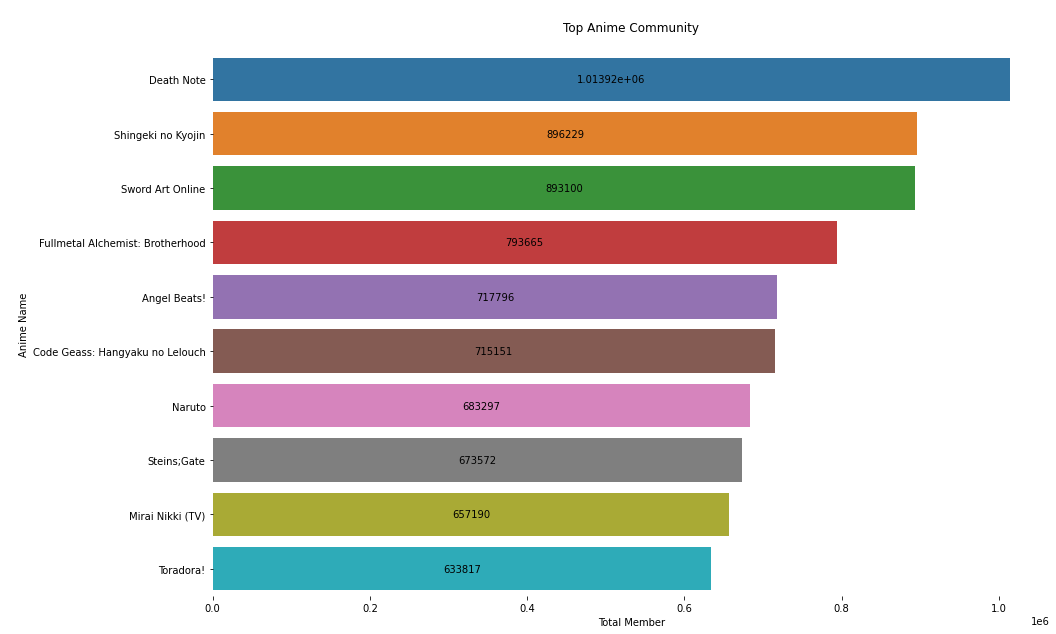

In [8]:
#Top anime community
top_anime = df_anime.sort_values(["members"],ascending=False)

plt.subplots(figsize=(15,10))
p = sns.barplot(x=top_anime["members"], y=top_anime["name"][:10])
p.axes.set_title("\nTop Anime Community\n")
plt.xlabel("Total Member")
plt.ylabel("\nAnime Name")
for container in p.containers:
    p.bar_label(container,label_type = "center", color = "black")

sns.despine(left=True, bottom=True)
plt.show()

In [9]:
# Check types of anime
df_anime['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

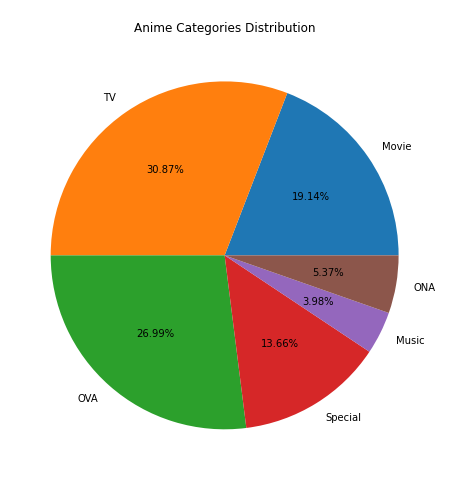

In [10]:
#Anime category
plt.subplots(figsize=(8, 8))

labels = 'Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'
sizes = [
    len(top_anime[top_anime["type"] == "Movie"]),
    len(top_anime[top_anime["type"] == "TV"]),
    len(top_anime[top_anime["type"] == "OVA"]),
    len(top_anime[top_anime["type"] == "Special"]),
    len(top_anime[top_anime["type"] == "Music"]),
    len(top_anime[top_anime["type"] == "ONA"])
]

plt.pie(sizes, labels=labels, autopct="%.2f%%")
plt.title("\nAnime Categories Distribution")
plt.show()

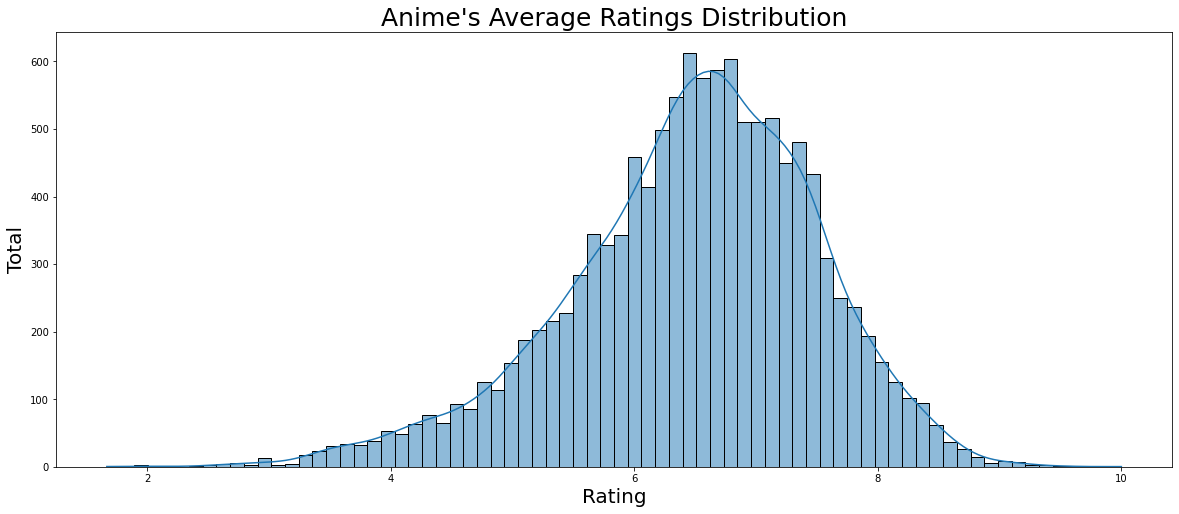

In [11]:
#Overall anime ratings
plt.figure(figsize=(20, 8))

sns.histplot(df_anime["rating"], kde=True)
plt.title("Anime's Average Ratings Distribution", fontsize=25)
plt.xlabel("Rating", fontsize=20)
plt.ylabel("Total", fontsize=20)
plt.show()

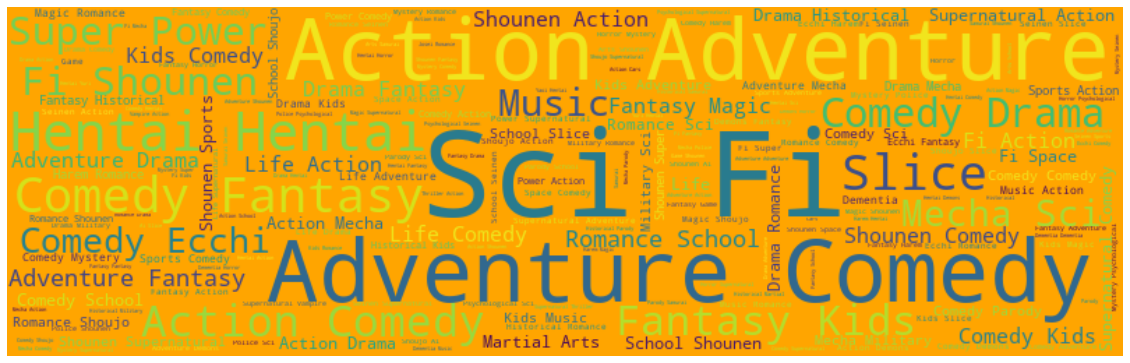

In [12]:
# Create a word cloud to visualize the distribution of popular genres
wordcloud = WordCloud(width=800, height=250, background_color="orange").generate(df_anime["genre"].str.cat(sep=", "))

plt.figure(figsize=(20, 8)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
# Check null values
print("Percentages of null values: ")
for column, val in df_anime.isnull().sum().items():
    if val > 0:
        print(f"{column}: {val/len(df_anime)*100:.2f}%")

Percentages of null values: 
genre: 0.50%
type: 0.20%
rating: 1.87%


In [14]:
# Check duplicated values
df_anime[df_anime.duplicated()].shape[0]

0

In [15]:
# Check null values
print("Percentages of null values: ")
for column, val in df_rating.isnull().sum().items():
    if val > 0:
        print(f"{column}: {val/len(df_rating)*100:.2f}%")

Percentages of null values: 


In [16]:
# Check duplicated values
df_rating[df_rating.duplicated()].shape[0]

1

In [17]:
# Check unique value of episodes
df_anime['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [18]:
df_anime[df_anime['episodes']=='Unknown'].head()

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400


# Preparing the dataset

In [19]:
def get_anime_feature_map(df_anime):
    ## cleaning names
    # df_anime['name'] = df_anime['name'].apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', re.sub(r'&#(\d)+;', '', x)))
    # df_anime = df_anime[df_anime['name'] != '']
    
    # ## Imputing episodes based on type of anime(mean value)
    tmp = df_anime[df_anime.episodes != 'Unknown'][['type', 'episodes']]
    tmp['episodes'] = tmp['episodes'].astype(int)
    tmp = tmp.groupby('type').mean().to_dict()['episodes']
    df_anime['episodes'] = df_anime.apply(lambda x: tmp.get(x['type'], 1) if (x['episodes'] == 'Unknown') else x['episodes'], axis=1)
    df_anime['episodes'] = df_anime['episodes'].astype(int)
    
    ## Imputing rating with the mean rating
    df_anime['rating'] = df_anime['rating'].fillna(df_anime['rating'].mean())
    
    #Imputing genre with extra '' class
    df_anime['genre'] = df_anime['genre'].apply(lambda x: [g.strip() for g in (x.split(',') if (type(x) == str) else [''])])
    mat = df_anime.to_numpy()
    genres = mat[:,2]
    
    mlb = MultiLabelBinarizer()
    mlb.fit(genres)
    
    ## Imputing type column with extra '' class
    df_anime['type'] = df_anime['type'].fillna('')
    
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(np.array(list(set(df_anime['type']))).reshape(-1, 1))
    
    df_anime['genre'] = df_anime['genre'].apply(lambda x: mlb.transform([x])[0])
    df_anime['type'] = df_anime['type'].apply(lambda x: ohe.transform([[x]])[0])
    
    ## normalize ratings and members
    df_anime['rating'] = (df_anime['rating'] - df_anime['rating'].min())/(df_anime['rating'].max()-df_anime['rating'].min())
    df_anime['members'] = (df_anime['members'] - df_anime['members'].min())/(df_anime['members'].max()-df_anime['members'].min())
    
    ## generating feature_map
    anime_feature_map = {}
    for idx, row in tqdm(df_anime.iterrows()):
        anime_feature_map[row["anime_id"]] = list(row["genre"]) + list(row["type"]) + [row["rating"], row["members"]]
        
    return anime_feature_map, mlb, ohe

In [20]:
anime_feature_map, mlb, ohe = get_anime_feature_map(df_anime)

12294it [00:01, 11889.41it/s]


In [21]:
# df_rating.head()
df_rating['anime_features'] = df_rating['anime_id'].apply(lambda x: anime_feature_map.get(x))
df_rating = df_rating[~df_rating.anime_features.isna()]
df_rating = df_rating[df_rating['rating'] != -1]

In [22]:
df_rating.head()

,user_id,anime_id,rating,anime_features
47,1,8074,10,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
81,1,11617,10,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, ..."
83,1,11757,10,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
101,1,15451,10,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, ..."
153,2,11771,10,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
user_count = df_rating.groupby('user_id').count()['rating']
df_rating = df_rating[df_rating['user_id'].apply(lambda x: 5 <= user_count[x] <= 100)]

In [25]:
user_idx_map = {u: e for e, u in enumerate(df_rating.user_id.unique())}
anime_idx_map = {i: e for e, i in enumerate(df_rating.anime_id.unique())}

In [26]:
df_rating["user_idx"] = df_rating["user_id"].apply(lambda x: user_idx_map[x])
df_rating["anime_idx"] = df_rating["anime_id"].apply(lambda x: anime_idx_map[x])

In [27]:
print(df_rating["user_idx"].max())
print(df_rating["anime_idx"].max())

41171
7185


In [28]:
df_rating.head()

,user_id,anime_id,rating,anime_features,user_idx,anime_idx
156,3,20,8,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
157,3,154,6,"[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,1
158,3,170,9,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,2
159,3,199,10,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,3
160,3,225,9,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,4


# Splitting the dataset

In [29]:
df_rating_train, df_rating_test = train_test_split(df_rating, test_size=0.1, stratify=df_rating.user_id, random_state=93)

In [30]:
X_train = [
    df_rating_train['user_idx'].values,
    df_rating_train['anime_idx'].values,
    np.array([np.array(t) for t in df_rating_train['anime_features']])
]
y_train = df_rating_train['rating'].values

X_test = [
    df_rating_test['user_idx'].values,
    df_rating_test['anime_idx'].values,
    np.array([np.array(t) for t in df_rating_test['anime_features']])
]
y_test = df_rating_test['rating'].values

# Our model

# Training

100%|██████████| 12294/12294 [00:01<00:00, 12122.96it/s]


Train on 1272119 samples, validate on 141347 samples
Epoch 1/100
1271360/1272119 [============================>.] - ETA: 0s - loss: 0.5461 - mean_absolute_error: 0.8274

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.39486, saving model to best_model_weighted.h5
1272119/1272119 [==============================] - 87s 68us/sample - loss: 0.5460 - mean_absolute_error: 0.8273 - val_loss: 0.3949 - val_mean_absolute_error: 0.7129
Epoch 2/100
1271936/1272119 [============================>.] - ETA: 0s - loss: 0.3643 - mean_absolute_error: 0.6808
Epoch 00002: val_loss improved from 0.39486 to 0.33764, saving model to best_model_weighted.h5
1272119/1272119 [==============================] - 86s 68us/sample - loss: 0.3643 - mean_absolute_error: 0.6808 - val_loss: 0.3376 - val_mean_absolute_error: 0.6567
Epoch 3/100
1271488/1272119 [============================>.] - ETA: 0s - loss: 0.3332 - mean_absolute_error: 0.6597
Epoch 00003: val_loss improved from 0.33764 to 0.31287, saving model to best_model_weighted.h5
1272119/1272119 [==============================] - 86s 67us/sample - loss: 0.3332 - mean_absolute_error: 0.6597 - val_loss: 0.3129 - val_mean_absolute_error

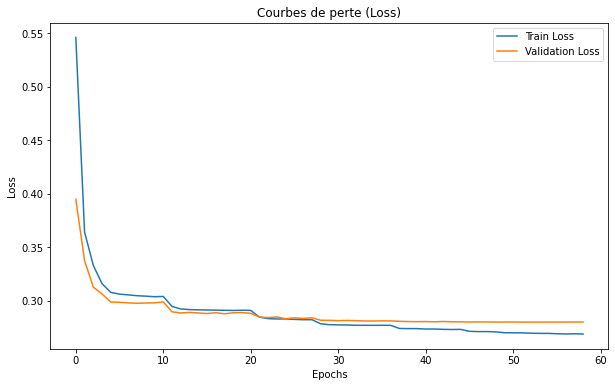

In [72]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Chargement des données
df_anime = pd.read_csv("/kaggle/input/rsanimes/anime.csv")
df_rating = pd.read_csv("/kaggle/input/rsanimes/rating.csv")

def get_anime_feature_map(df_anime):
    tmp = df_anime[df_anime.episodes != 'Unknown'][['type', 'episodes']]
    tmp['episodes'] = tmp['episodes'].astype(int)
    tmp = tmp.groupby('type').mean().to_dict()['episodes']
    df_anime['episodes'] = df_anime.apply(lambda x: tmp.get(x['type'], 1) if (x['episodes'] == 'Unknown') else x['episodes'], axis=1)
    df_anime['episodes'] = df_anime['episodes'].astype(int)
    df_anime['rating'] = df_anime['rating'].fillna(df_anime['rating'].mean())
    df_anime['genre'] = df_anime['genre'].apply(lambda x: [g.strip() for g in (x.split(',') if (type(x) == str) else [''])])
    
    mlb = MultiLabelBinarizer()
    mlb.fit(df_anime['genre'])

    df_anime['type'] = df_anime['type'].fillna('')
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(np.array(list(set(df_anime['type']))).reshape(-1, 1))

    df_anime['genre'] = df_anime['genre'].apply(lambda x: mlb.transform([x])[0])
    df_anime['type'] = df_anime['type'].apply(lambda x: ohe.transform([[x]])[0])

    df_anime['rating'] = (df_anime['rating'] - df_anime['rating'].min()) / (df_anime['rating'].max() - df_anime['rating'].min())
    df_anime['members'] = (df_anime['members'] - df_anime['members'].min()) / (df_anime['members'].max() - df_anime['members'].min())

    anime_feature_map = {}
    for idx, row in tqdm(df_anime.iterrows(), total=df_anime.shape[0]):
        anime_feature_map[row['anime_id']] = list(row['genre']) + list(row['type']) + [row['rating'], row['members']]

    return anime_feature_map, mlb, ohe

anime_feature_map, mlb, ohe = get_anime_feature_map(df_anime)

df_rating['anime_features'] = df_rating['anime_id'].apply(lambda x: anime_feature_map.get(x))
df_rating = df_rating[~df_rating.anime_features.isna()]
df_rating = df_rating[df_rating['rating'] != -1]
user_count = df_rating.groupby('user_id').count()['rating']
df_rating = df_rating[df_rating['user_id'].apply(lambda x: 5 <= user_count[x] <= 100)]

user_idx_map = {u: e for e, u in enumerate(df_rating.user_id.unique())}
anime_idx_map = {i: e for e, i in enumerate(df_rating.anime_id.unique())}

df_rating['user_idx'] = df_rating['user_id'].apply(lambda x: user_idx_map[x])
df_rating['anime_idx'] = df_rating['anime_id'].apply(lambda x: anime_idx_map[x])

# Division des données
df_rating_train, df_rating_test = train_test_split(df_rating, test_size=0.1, stratify=df_rating.user_id, random_state=93)

X_train = [
    df_rating_train['user_idx'].values,
    df_rating_train['anime_idx'].values,
    np.array([np.array(t) for t in df_rating_train['anime_features']])
]

y_train = df_rating_train['rating'].values

X_test = [
    df_rating_test['user_idx'].values,
    df_rating_test['anime_idx'].values,
    np.array([np.array(t) for t in df_rating_test['anime_features']])
]

y_test = df_rating_test['rating'].values

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

def create_model(n_users, user_embed_size_dot, user_embed_size_concat, n_items, item_embed_size, item_feature_len, regularization=1e-3):
    item_features = Input(shape=(item_feature_len,), name="item_features")

    user_inp = Input(shape=(1,), dtype='int32', name="user_embed")
    user_embed = Embedding(n_users, user_embed_size_dot, embeddings_initializer="glorot_uniform", embeddings_regularizer=tf.keras.regularizers.l2(regularization))(user_inp)
    user_embed_c = Embedding(n_users, user_embed_size_concat, embeddings_initializer="glorot_uniform", embeddings_regularizer=tf.keras.regularizers.l2(regularization))(user_inp)

    item_inp = Input(shape=(1,), dtype='int32', name="item_embed")
    item_embed = Embedding(n_items, item_embed_size, embeddings_initializer="glorot_uniform", embeddings_regularizer=tf.keras.regularizers.l2(regularization))(item_inp)

    user_item_dot = Dot(axes=2)([user_embed, item_embed])
    user_item_dot = Flatten()(user_item_dot)

    weighted_item_features = Dense(item_feature_len, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization))(item_features)

    user_item_concat = Concatenate(axis=1)([Flatten()(user_embed_c), weighted_item_features])

    hidden1 = Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization))(user_item_concat)
    hidden1 = BatchNormalization()(hidden1)
    hidden1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization))(hidden1)
    hidden2 = BatchNormalization()(hidden2)
    hidden2 = Dropout(0.5)(hidden2)

    hidden3 = Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization))(hidden2)
    hidden3 = BatchNormalization()(hidden3)
    hidden3 = Dropout(0.3)(hidden3)

    dot_hidden_concat = Concatenate(axis=1)([hidden3, user_item_dot])

    output = Dense(1, activation="linear")(dot_hidden_concat)

    model = Model([user_inp, item_inp, item_features], output)
    return model

model_weighted = create_model(
    n_users=len(user_idx_map),
    user_embed_size_dot=32,
    user_embed_size_concat=32,
    n_items=len(anime_idx_map),
    item_embed_size=32,
    item_feature_len=len(df_rating['anime_features'].iloc[0])
)

model_weighted.compile(optimizer=Adam(1e-4), loss="huber_loss", metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
model_chkpoint = ModelCheckpoint('best_model_weighted.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model_weighted.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop, model_chkpoint, reduce_lr]
)

results = model_weighted.evaluate(X_test, y_test, verbose=1)
print("Test Loss, Test MAE:", results)

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbes de perte (Loss)')
plt.show()


In [57]:
y_pred = model_weightedd.predict(X_test).flatten()

In [58]:
# Évaluation
results = model_weightedd.evaluate(X_test, y_test, verbose=1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Loss, Test MAE:", results)
print(f"Test RMSE: {rmse:.4f}")

Test Loss, Test MAE: [0.2761022962006051, 0.59640884]
Test RMSE: 0.7985


In [ ]:
# Poids complets après entraînement
model_weightedd.save_weights('/kaggle/working/anime_model_weights.h5')
print(f"Weights saved")

In [ ]:
import pickle
#Sauvegarder les mappings des utilisateurs et des animes
with open('/kaggle/working/user_idx_map.pkl', 'wb') as f:
    pickle.dump(user_idx_map, f)

with open('/kaggle/working/anime_idx_map.pkl', 'wb') as f:
    pickle.dump(anime_idx_map, f)


In [ ]:
#anime_feature_map (caractéristiques des animes)
import pickle
with open('/kaggle/working/anime_feature_map.pkl', 'wb') as f:
    pickle.dump(anime_feature_map, f)


In [ ]:
# Charger le modèle sauvegardé
model = load_model('/kaggle/working/best_model_weighted.h5')

# Charger les autres objets nécessaires
with open('/kaggle/working/anime_idx_map.pkl', 'rb') as f:
    anime_idx_map = pickle.load(f)

with open('/kaggle/working/user_idx_map.pkl', 'rb') as f:
    user_idx_map = pickle.load(f)

with open('/kaggle/working/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('/kaggle/working/anime_feature_map.pkl', 'rb') as f:
    anime_feature_map = pickle.load(f)

# Sauvegarder scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)